In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from tqdm.notebook import tqdm

In [2]:
from sklearn.model_selection import StratifiedKFold

In [4]:
# загрузим датасеты, больше даннных -- не меньше данных
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

In [5]:
# посмотрим на соотношение классов

In [6]:
data_1.groupby('Category').count()

,text
Category,
ham,4825
spam,747


In [7]:
data_2.groupby('v1').count()

,text
v1,
ham,4825
spam,747


In [8]:
data_3.groupby('label').count()

,text
label,
ham,3672
spam,1499


In [9]:
# первые два датасета __очень__ сильно пересекаются. Будем считать что это один и тот же датасет.
# Все три датасета можно объединить только если они стилистически похожи. посмотрим
print(data_1.text.iloc[10])
print('_________')
print(data_3.text.iloc[5])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
_________
Subject: ehronline web address change
this message is intended for ehronline users only .
due to a recent change to ehronline , the url ( aka " web address " ) for accessing ehronline needs to be changed on your computer . the change involves adding the letter " s " to the " http " reference in the url . the url for accessing ehronline should be : https : / / ehronline . enron . com .
this change should be made by those who have added the url as a favorite on the browser .


Первое что бросается в глаза -- в последнем датасете более длинные сообщения и везде присуствует заголовок. Обе этих проблемы можно обыграть по-разному, но главное убрать слово subject. Иначе модель может подумать, что это хороший признак для спама (2/3 всего спама будет начинаться с него, против менее чем половины хама).

In [10]:
data_3.text = data_3.text.apply(lambda x: x.replace('Subject: ', '').replace('\n', ' ').replace('\r', ''))

In [11]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


In [12]:
def train_val(clf, X_train, X_test, y_train, y_test, vectorizer, full=False):
    # векторизуем каждое предложение, обучаясь только на тренировочной подвыборке
    train_vec = vectorizer.fit_transform(X_train) 
    test_vec  = vectorizer.transform(X_test)
    
    # обучаем классификатор
    clf.fit(train_vec, y_train)
    
    # вычисляем предсказания классификкатора на тестовой подвыборке
    pred = clf.predict(test_vec)

    # при необходиомости выводим матрицу ошибок и расширенный отчет по метрикам
    if full:
        plot_confusion_matrix(clf, test_vec, y_test)

        print(classification_report(y_test, pred))
    
    # вычисляем фи-коэффициент как основную метрику (читайте ниже почему она)
    return matthews_corrcoef(y_test, pred)

In [13]:
def cross_val(clf, data, vectorizer, full=False):
    # напишем свою кросс-валидацию, потому что это быстрее, 
    # чем вспоминать как без даталиков использовать скалерн-пайплайн
    res = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    X, y = data, data.index
    # для каждого разбиения
    for train_indxs, test_indxs in tqdm(kf.split(X, y), total=5):
        # отделяем трейн от теста
        train_data, test_data = data.iloc[train_indxs], data.iloc[test_indxs]
        
        X_train, y_train = train_data.text.values, train_data.index
        X_test, y_test = test_data.text.values, test_data.index
        
        # обучаемся и валидируемся
        res.append(train_val(clf, X_train, X_test, y_train, y_test, vectorizer))
    return res

In [14]:
# делим на обучающую и тестовые подвыборки для получения более подробных метрик
X_train, X_test, y_train, y_test = train_test_split(
    data.text.values, data.index, test_size = 0.2,stratify=data.index)

In [15]:
# векторизуем обычным tfidf с выкидыванием популярных слов и переводом текста в нижний регистр
vectorizer = TfidfVectorizer(  
    lowercase=True,      
    stop_words='english' 
)


[0.7105 0.7274 0.7355 0.728  0.7298] 0.7263
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1685
           1       1.00      0.57      0.73       470

    accuracy                           0.91      2155
   macro avg       0.95      0.79      0.84      2155
weighted avg       0.92      0.91      0.90      2155



0.7150827792929976

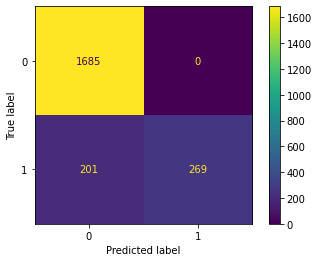

In [16]:
# выбираем классификатор
classifier = MultinomialNB()

# проводим кроссвалидацию 
res = cross_val(classifier, data, vectorizer)

# смотрим на результаты кроссвалидации и подробные результаты точечной проверки
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train, X_test, y_train, y_test, vectorizer, full=True)


[0.864  0.8697 0.8596 0.8638 0.8611] 0.8636
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1685
           1       0.99      0.83      0.91       470

    accuracy                           0.96      2155
   macro avg       0.97      0.92      0.94      2155
weighted avg       0.96      0.96      0.96      2155



0.8867857549768832

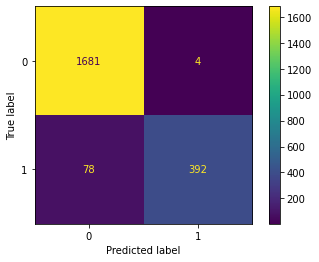

In [17]:
classifier = RandomForestClassifier()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train, X_test, y_train, y_test, vectorizer, full=True)


[0.8686 0.8726 0.8612 0.8555 0.8654] 0.8647
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1685
           1       0.98      0.84      0.90       470

    accuracy                           0.96      2155
   macro avg       0.97      0.92      0.94      2155
weighted avg       0.96      0.96      0.96      2155



0.8836425165187017

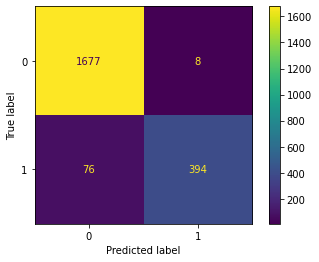

In [18]:
classifier = SVC()
res = cross_val(classifier, data, vectorizer)
print(np.round(res,4), np.round(sum(res)/len(res), 4))
train_val(classifier, X_train, X_test, y_train, y_test, vectorizer, full=True)

Бейзлайн показывает, что полнота (она же чувствительность в рамках нашей бинарной классификации) определения спама значительно проседает и это в целом основная проблема. То есть надо сосредоточиться на этой проблеме. 

Также в столь несбалансированной выборке смотреть только на f1-score не кажется хорошей практикой, более релевантной показала себя MCC, которая учитывает все значения в таблице ошибок.